__importing Libraries__

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score,mean_absolute_percentage_error

__Data Understanding__

In [10]:
hcp = pd.read_csv("household_power_consumption.txt",sep = ';', low_memory=False)

In [11]:
hcp.shape

(113606, 9)

In [12]:
hcp.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [13]:
hcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113606 entries, 0 to 113605
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Date                   113606 non-null  object 
 1   Time                   113606 non-null  object 
 2   Global_active_power    113606 non-null  object 
 3   Global_reactive_power  113606 non-null  object 
 4   Voltage                113606 non-null  object 
 5   Global_intensity       113606 non-null  object 
 6   Sub_metering_1         113606 non-null  object 
 7   Sub_metering_2         113606 non-null  object 
 8   Sub_metering_3         113598 non-null  float64
dtypes: float64(1), object(8)
memory usage: 7.8+ MB


__EDA Process / Data Preprocessing__

In [14]:
hcp['Datetime'] = pd.to_datetime(hcp['Date'] + ' ' + hcp['Time'], format='%d/%m/%Y %H:%M:%S')

In [15]:
hcp.drop(['Time','Date'], axis=1, inplace=True)
hcp.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime
0,4.216,0.418,234.840,18.400,0.000,1.000,17.0,2006-12-16 17:24:00
1,5.360,0.436,233.630,23.000,0.000,1.000,16.0,2006-12-16 17:25:00
2,5.374,0.498,233.290,23.000,0.000,2.000,17.0,2006-12-16 17:26:00
3,5.388,0.502,233.740,23.000,0.000,1.000,17.0,2006-12-16 17:27:00
4,3.666,0.528,235.680,15.800,0.000,1.000,17.0,2006-12-16 17:28:00


In [16]:
hcp['Global_active_power'] = pd.to_numeric(hcp['Global_active_power'], errors='coerce')
hcp['Global_reactive_power'] = pd.to_numeric(hcp['Global_reactive_power'], errors='coerce')
hcp['Voltage'] = pd.to_numeric(hcp['Voltage'], errors='coerce')
hcp['Sub_metering_1'] = pd.to_numeric(hcp['Sub_metering_1'], errors='coerce')
hcp['Sub_metering_2'] = pd.to_numeric(hcp['Sub_metering_2'], errors='coerce')
hcp['Global_intensity'] = pd.to_numeric(hcp['Global_intensity'], errors='coerce')

In [17]:
hcp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113606 entries, 0 to 113605
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Global_active_power    113598 non-null  float64       
 1   Global_reactive_power  113598 non-null  float64       
 2   Voltage                113598 non-null  float64       
 3   Global_intensity       113598 non-null  float64       
 4   Sub_metering_1         113598 non-null  float64       
 5   Sub_metering_2         113598 non-null  float64       
 6   Sub_metering_3         113598 non-null  float64       
 7   Datetime               113606 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(7)
memory usage: 6.9 MB


In [18]:
hcp.isnull().sum()

,0
Global_active_power,8
Global_reactive_power,8
Voltage,8
Global_intensity,8
Sub_metering_1,8
Sub_metering_2,8
Sub_metering_3,8
Datetime,0


In [19]:
hcp['Global_active_power'] = hcp['Global_active_power'].fillna(hcp['Global_active_power'].median())

In [20]:
hcp['Global_reactive_power'] = hcp['Global_reactive_power'].fillna(hcp['Global_reactive_power'].median())
hcp['Voltage'] = hcp['Voltage'].fillna(hcp['Voltage'].median())
hcp['Global_intensity'] = hcp['Global_intensity'].fillna(hcp['Global_intensity'].median())
hcp['Sub_metering_1'] = hcp['Sub_metering_1'].fillna(hcp['Sub_metering_1'].median())
hcp['Sub_metering_2'] = hcp['Sub_metering_2'].fillna(hcp['Sub_metering_2'].median())
hcp['Sub_metering_3'] = hcp['Sub_metering_3'].fillna(hcp['Sub_metering_3'].median())

In [21]:
hcp.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0


__Identifying and treating the outliers__

In [22]:
numerical_cols = ['Global_active_power', 'Global_reactive_power', 'Voltage',
                  'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

# --- IQR Method ---
def detect_outliers_iqr(df, cols):
    outlier_indices = []
    for col in cols:
        Q1 = df[col].quantile(0.25)  # 25th percentile
        Q3 = df[col].quantile(0.75)  # 75th percentile
        IQR = Q3 - Q1

        # Define bounds
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.extend(outliers)

    return set(outlier_indices)

iqr_outliers = detect_outliers_iqr(hcp, numerical_cols)
print(f"Outliers detected using IQR Method: {len(iqr_outliers)} rows")

Outliers detected using IQR Method: 14871 rows


In [23]:
# --- Z-Score Method ---
def detect_outliers_zscore(df, cols, threshold=3):
    outlier_indices = []
    for col in cols:
        mean = df[col].mean()
        std_dev = df[col].std()

        # Compute Z-scores
        z_scores = (df[col] - mean) / std_dev

        # Identify outliers
        outliers = df[np.abs(z_scores) > threshold].index
        outlier_indices.extend(outliers)

    return set(outlier_indices)

zscore_outliers = detect_outliers_zscore(hcp, numerical_cols)
print(f"Outliers detected using Z-Score Method: {len(zscore_outliers)} rows")

Outliers detected using Z-Score Method: 8079 rows


In [24]:
# --- Compare Outliers ---
common_outliers = iqr_outliers & zscore_outliers
print(f"Common outliers between IQR and Z-Score: {len(common_outliers)} rows")

Common outliers between IQR and Z-Score: 8024 rows


__Removing Outliers__

In [25]:
hcp_cleaned = hcp.drop(index=zscore_outliers)

print(f"Data size after removing outliers: {hcp_cleaned.shape}")
hcp = hcp_cleaned

Data size after removing outliers: (105527, 8)


__Feature Engineering__

In [26]:
# Extract date and time features
hcp['hour'] = hcp['Datetime'].dt.hour
hcp['day_of_week'] = hcp['Datetime'].dt.dayofweek
hcp['year'] = hcp['Datetime'].dt.year

In [27]:
# Total energy consumption
hcp['total_energy'] = hcp['Sub_metering_1'] + hcp['Sub_metering_2'] + hcp['Sub_metering_3']

# Proportion of energy consumption for each sub-metering area
hcp['Sub_metering_1_ratio'] = hcp['Sub_metering_1'] / hcp['total_energy']
hcp['Sub_metering_2_ratio'] = hcp['Sub_metering_2'] / hcp['total_energy']
hcp['Sub_metering_3_ratio'] = hcp['Sub_metering_3'] / hcp['total_energy']

# Dealing with nan values
hcp['Sub_metering_1_ratio'] = hcp['Sub_metering_1'].fillna(0.0)
hcp['Sub_metering_2_ratio'] = hcp['Sub_metering_2'].fillna(0.0)
hcp['Sub_metering_3_ratio'] = hcp['Sub_metering_3'].fillna(0.0)

In [28]:
hcp.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105527 entries, 0 to 113591
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Global_active_power    105527 non-null  float64       
 1   Global_reactive_power  105527 non-null  float64       
 2   Voltage                105527 non-null  float64       
 3   Global_intensity       105527 non-null  float64       
 4   Sub_metering_1         105527 non-null  float64       
 5   Sub_metering_2         105527 non-null  float64       
 6   Sub_metering_3         105527 non-null  float64       
 7   Datetime               105527 non-null  datetime64[ns]
 8   hour                   105527 non-null  int32         
 9   day_of_week            105527 non-null  int32         
 10  year                   105527 non-null  int32         
 11  total_energy           105527 non-null  float64       
 12  Sub_metering_1_ratio   105527 non-null  float64  

In [29]:
hcp.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,hour,day_of_week,year,total_energy,Sub_metering_1_ratio,Sub_metering_2_ratio,Sub_metering_3_ratio
0,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,17,5,2006,18.0,0.0,1.0,17.0
1,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,17,5,2006,17.0,0.0,1.0,16.0
13,5.268,0.398,232.91,22.6,0.0,2.0,17.0,2006-12-16 17:37:00,17,5,2006,19.0,0.0,2.0,17.0
14,4.054,0.422,235.24,17.6,0.0,1.0,17.0,2006-12-16 17:38:00,17,5,2006,18.0,0.0,1.0,17.0
15,3.384,0.282,237.14,14.2,0.0,0.0,17.0,2006-12-16 17:39:00,17,5,2006,17.0,0.0,0.0,17.0


In [30]:
hcp.isnull().sum()

,0
Global_active_power,0
Global_reactive_power,0
Voltage,0
Global_intensity,0
Sub_metering_1,0
Sub_metering_2,0
Sub_metering_3,0
Datetime,0
hour,0
day_of_week,0


__Scalling the Features__

In [31]:
scaler = StandardScaler()
features_to_scale = ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity',
                     'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3','total_energy',
                     'Sub_metering_1_ratio','Sub_metering_2_ratio','Sub_metering_3_ratio']
hcp[features_to_scale] = scaler.fit_transform(hcp[features_to_scale])

In [32]:
hcp.shape

(105527, 15)

__KNN Regression__

__Splitting X and Y__

In [33]:
hcp_2 = hcp.drop({"total_energy","Sub_metering_1_ratio","Sub_metering_2_ratio","Sub_metering_3_ratio","Datetime"},axis = 1)

In [34]:
hcp_2.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,hour,day_of_week,year
0,2.710886,2.942310,-2.010243,2.870881,-0.116429,0.266941,1.237041,17,5,2006
1,3.775962,3.116804,-2.395359,3.895045,-0.116429,0.266941,1.119172,17,5,2006
13,3.690309,2.748427,-2.624518,3.805987,-0.116429,0.800637,1.237041,17,5,2006
14,2.560062,2.981086,-1.882932,2.692766,-0.116429,0.266941,1.237041,17,5,2006
15,1.936285,1.623905,-1.278206,1.935775,-0.116429,-0.266754,1.237041,17,5,2006


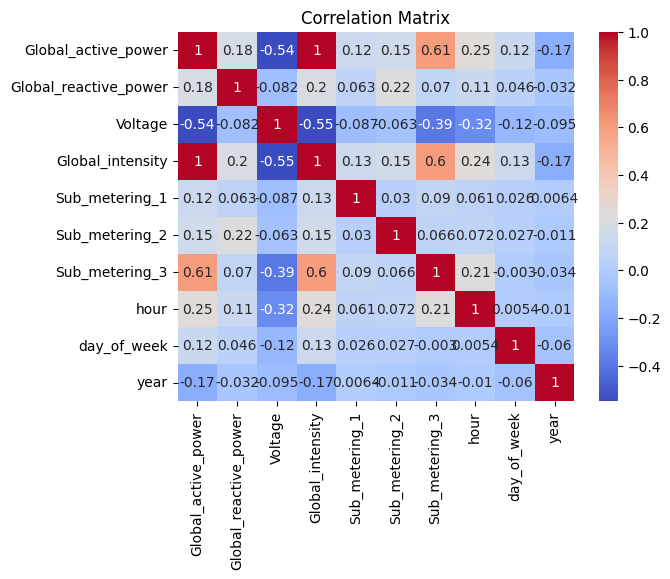

In [35]:
sns.heatmap(hcp_2.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

Since, Global_active_power and Global_intensity are highly correlated and doesnot give any new predictions, Global_intensity column is dropped.

In [36]:
hcp_2 = hcp_2.drop("Global_intensity",axis = 1)

In [37]:
hcp_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 105527 entries, 0 to 113591
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    105527 non-null  float64
 1   Global_reactive_power  105527 non-null  float64
 2   Voltage                105527 non-null  float64
 3   Sub_metering_1         105527 non-null  float64
 4   Sub_metering_2         105527 non-null  float64
 5   Sub_metering_3         105527 non-null  float64
 6   hour                   105527 non-null  int32  
 7   day_of_week            105527 non-null  int32  
 8   year                   105527 non-null  int32  
dtypes: float64(6), int32(3)
memory usage: 6.8 MB


In [38]:
Y = hcp_2[["Global_active_power"]]
X = hcp_2.drop("Global_active_power",axis =1)

In [39]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.30,random_state=1)

In [40]:
from sklearn.neighbors import KNeighborsRegressor
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train,Y_train)

KNeighborsRegressor(n_neighbors=3)

In [41]:
ypred_test=knn_regressor.predict(X_test)
# Evaluate the model
print("Metrics for Testing:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_test, ypred_test))
print("Mean Squared Error (MSE):", mean_squared_error(Y_test, ypred_test))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_test, ypred_test)))
print("R-squared (R2) Score:", r2_score(Y_test,ypred_test))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_test, ypred_test) * 100)

Metrics for Testing:
Mean Absolute Error (MAE): 0.234789392275662
Mean Squared Error (MSE): 0.21707174747048835
Root Mean Squared Error (RMSE): 0.4659095915201664
R-squared (R2) Score: 0.7815803637210702
Mean Absolute Percent Error (MAPE): 223.6349885361887


In [42]:
ypred_train=knn_regressor.predict(X_train)
# Evaluate the model
print("Metrics for Training:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_train, ypred_train))
print("Mean Squared Error (MSE):", mean_squared_error(Y_train, ypred_train))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_train, ypred_train)))
print("R-squared (R2) Score:", r2_score(Y_train,ypred_train))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_train, ypred_train) * 100)

Metrics for Training:
Mean Absolute Error (MAE): 0.15416503648665306
Mean Squared Error (MSE): 0.10514185443923874
Root Mean Squared Error (RMSE): 0.3242558471935992
R-squared (R2) Score: 0.8951346827450959
Mean Absolute Percent Error (MAPE): 143.10228158270166


__Random Forest Regression__

In [43]:
from sklearn.ensemble import RandomForestRegressor
RFmodel = RandomForestRegressor(n_estimators = 100, random_state = 10)
RFmodel.fit(X_train,Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=10)

In [44]:
ypred_test=RFmodel.predict(X_test)
# Evaluate the model
print("Metrics for Testing:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_test, ypred_test))
print("Mean Squared Error (MSE):", mean_squared_error(Y_test, ypred_test))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_test, ypred_test)))
print("R-squared (R2) Score:", r2_score(Y_test,ypred_test))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_test, ypred_test) * 100)

Metrics for Testing:
Mean Absolute Error (MAE): 0.2571327582529565
Mean Squared Error (MSE): 0.20898196425910012
Root Mean Squared Error (RMSE): 0.45714545197245493
R-squared (R2) Score: 0.7897203797627572
Mean Absolute Percent Error (MAPE): 250.6598736996103


In [45]:
ypred_train=RFmodel.predict(X_train)
# Evaluate the model
print("Metrics for Training:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_train, ypred_train))
print("Mean Squared Error (MSE):", mean_squared_error(Y_train, ypred_train))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_train, ypred_train)))
print("R-squared (R2) Score:", r2_score(Y_train,ypred_train))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_train, ypred_train) * 100)

Metrics for Training:
Mean Absolute Error (MAE): 0.0968896525314708
Mean Squared Error (MSE): 0.03161124868939152
Root Mean Squared Error (RMSE): 0.17779552494197237
R-squared (R2) Score: 0.968471893136026
Mean Absolute Percent Error (MAPE): 87.51241681984287


**Gradient Boosting**

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
GBModel = GradientBoostingRegressor(random_state=1)
GBModel.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py:672: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


GradientBoostingRegressor(random_state=1)

In [47]:
ypred_test=RFmodel.predict(X_test)
# Evaluate the model
print("Metrics for Testing:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_test, ypred_test))
print("Mean Squared Error (MSE):", mean_squared_error(Y_test, ypred_test))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_test, ypred_test)))
print("R-squared (R2) Score:", r2_score(Y_test,ypred_test))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_test, ypred_test) * 100)

Metrics for Testing:
Mean Absolute Error (MAE): 0.2571327582529565
Mean Squared Error (MSE): 0.20898196425910012
Root Mean Squared Error (RMSE): 0.45714545197245493
R-squared (R2) Score: 0.7897203797627572
Mean Absolute Percent Error (MAPE): 250.6598736996103


In [48]:
ypred_train=RFmodel.predict(X_train)
# Evaluate the model
print("Metrics for Training:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_train, ypred_train))
print("Mean Squared Error (MSE):", mean_squared_error(Y_train, ypred_train))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_train, ypred_train)))
print("R-squared (R2) Score:", r2_score(Y_train,ypred_train))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_train, ypred_train) * 100)

Metrics for Training:
Mean Absolute Error (MAE): 0.0968896525314708
Mean Squared Error (MSE): 0.03161124868939152
Root Mean Squared Error (RMSE): 0.17779552494197237
R-squared (R2) Score: 0.968471893136026
Mean Absolute Percent Error (MAPE): 87.51241681984287


**Neural** **Networks**

In [49]:
from sklearn.neural_network import MLPRegressor
MLPModel = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu', solver='sgd', max_iter=1000, random_state=42)
MLPModel.fit(X_train, Y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:1645: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42,
             solver='sgd')

In [53]:
ypred_test=MLPModel.predict(X_test)
# Evaluate the model
print("Metrics for Testing:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_test, ypred_test))
print("Mean Squared Error (MSE):", mean_squared_error(Y_test, ypred_test))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_test, ypred_test)))
print("R-squared (R2) Score:", r2_score(Y_test,ypred_test))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_test, ypred_test) * 100)

Metrics for Testing:
Mean Absolute Error (MAE): 905599665407041.1
Mean Squared Error (MSE): 8.201107539853448e+29
Root Mean Squared Error (RMSE): 905599665407041.1
R-squared (R2) Score: -8.25203162923222e+29
Mean Absolute Percent Error (MAPE): 1.2367539394387507e+18


In [52]:
ypred_train=MLPModel.predict(X_train)
# Evaluate the model
print("Metrics for Training:")
print("Mean Absolute Error (MAE):", mean_absolute_error(Y_train, ypred_train))
print("Mean Squared Error (MSE):", mean_squared_error(Y_train, ypred_train))
print("Root Mean Squared Error (RMSE):", np.sqrt(mean_squared_error(Y_train, ypred_train)))
print("R-squared (R2) Score:", r2_score(Y_train,ypred_train))
print("Mean Absolute Percent Error (MAPE):",mean_absolute_percentage_error(Y_train, ypred_train) * 100)

Metrics for Training:
Mean Absolute Error (MAE): 905599665407041.0
Mean Squared Error (MSE): 8.20110753985345e+29
Root Mean Squared Error (RMSE): 905599665407041.2
R-squared (R2) Score: -8.179537526659444e+29
Mean Absolute Percent Error (MAPE): 1.250891214513057e+18


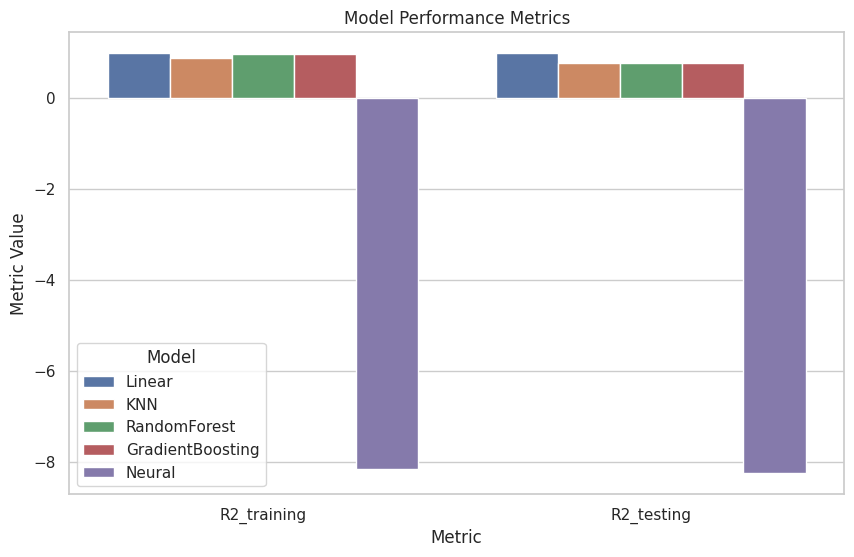

In [4]:
data = {
'Model': ['Linear','KNN','RandomForest','GradientBoosting','Neural'],
'R2_training': [0.99,0.89,0.96,0.96,-8.17],
'R2_testing': [0.99,0.78,0.78,0.78,-8.25]}

df = pd.DataFrame(data)

df_melted = pd.melt(df, id_vars=['Model'], var_name='Metric', value_name='Value')

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.barplot(x='Metric', y='Value', hue='Model', data=df_melted)
plt.title('Model Performance Metrics')
plt.ylabel('Metric Value')
plt.xlabel('Metric')
plt.legend(title='Model')
plt.show()